# Imports

In [1]:
import pandas as pd
import datetime
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn import metrics
from pygam import LogisticGAM
from sklearn import tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRFClassifier
from sklearn.model_selection import GridSearchCV

/home/charlie/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Loading the Data

In [2]:
historicalWeather = pd.read_csv('HistoricalWeather.csv')
historicalWeatherForecasts = pd.read_csv('HistoricalWeatherForecasts.csv')
historicalWildfires = pd.read_csv('Historical_Wildfires.csv')
landClass = pd.read_csv('LandClass.csv')
vegetationIndex = pd.read_csv('VegetationIndex.csv')

# Creating the Data Set

In [3]:
historicalWeather_pivot = historicalWeather.pivot(index=['Date']+['Region'], columns=['Parameter'])
historicalWeather_pivot = historicalWeather_pivot.dropna()
historicalWeather_pivot.head()
historicalWeather_pivot = historicalWeather_pivot.drop(columns=[('count()[unit: km^2]','Precipitation'),
                              ('count()[unit: km^2]', 'RelativeHumidity'),
                               ('count()[unit: km^2]', 'SoilWaterContent'),
                               ('count()[unit: km^2]',   'SolarRadiation'),
                               ('count()[unit: km^2]',      'Temperature')])

In [4]:
reform_dates = []
for i in historicalWildfires.iterrows():
    
    region = i[1][0]
    date = i[1][1]
    month = re.search('^(\d+)/', date)
    month = month.group(1)
    day = re.search('/(\d+)/', date)
    day = day.group(1)
    year = re.search('/(\d+)$', date)
    year = year.group(1)  
    
    date = datetime.datetime(int(year), int(month), int(day))
        
    reform_dates.append([date.strftime('%Y-%m-%d'), region])

historicalWeather_pivot['fire01'] = [1 if [i[0][0], i[0][1]] in reform_dates else 0 for i in tqdm(historicalWeather_pivot.iterrows())]


40404it [00:24, 1654.77it/s]


In [5]:
name_of_index = [] 
for i in historicalWeather_pivot.index:
    if i[1] == 'NSW':
        name_of_index.append(0)
    if i[1] == 'NT':
        name_of_index.append(1)
    if i[1] == 'QL':
        name_of_index.append(2)
    if i[1] == 'SA':
        name_of_index.append(3)
    if i[1] == 'TA':
        name_of_index.append(4)
    if i[1] == 'VI':
        name_of_index.append(5)
    if i[1] == 'WA':
        name_of_index.append(6)
        
historicalWeather_pivot.insert(0, 'NameToNum', name_of_index)
name_dummies = pd.get_dummies(historicalWeather_pivot.NameToNum)
historicalWeather_pivot = pd.concat([name_dummies, historicalWeather_pivot], axis=1)
historicalWeather_pivot

0  1  2  3  4  5  6  (NameToNum, )  \
Date       Region                                       
2005-01-01 NSW     1  0  0  0  0  0  0              0   
           NT      0  1  0  0  0  0  0              1   
           QL      0  0  1  0  0  0  0              2   
           SA      0  0  0  1  0  0  0              3   
           TA      0  0  0  0  1  0  0              4   
...               .. .. .. .. .. .. ..            ...   
2020-10-31 QL      0  0  1  0  0  0  0              2   
           SA      0  0  0  1  0  0  0              3   
           TA      0  0  0  0  1  0  0              4   
           VI      0  0  0  0  0  1  0              5   
           WA      0  0  0  0  0  0  1              6   

                   (count()[unit: km^2], WindSpeed)  (min(), Precipitation)  \
Date       Region                                                             
2005-01-01 NSW                         8.002343e+05                0.000000   
           NT                          1.357561e+06                0.000000   
           QL                          1.730605e+06                0.000000   
           SA                          9.913151e+05                0.000000   
           TA                          6.778526e+04                0.003973   
...                                             ...                     ...   
2020-10-31 QL                          1.730605e+06                0.000000   
           SA                          9.913151e+05                0.000000   
           TA                          6.778526e+04                0.000703   
           VI                          2.294532e+05                0.000000   
           WA                          2.528546e+06                0.000000   

                   ...  (mean(), SolarRadiation)  (mean(), Temperature)  \
Date       Region  ...                                                    
2005-01-01 NSW     ...                 26.749389              27.341182   
           NT      ...                 19.781791              29.881492   
           QL      ...                 27.056979              28.842866   
           SA      ...                 27.142643              30.793675   
           TA      ...                 26.755711              11.788805   
...                ...                       ...                    ...   
2020-10-31 QL      ...                 28.745128              24.777835   
           SA      ...                 26.530568              18.947783   
           TA      ...                 21.782732              11.648813   
           VI      ...                 19.553751              13.167147   
           WA      ...                 26.746413              28.090392   

                   (mean(), WindSpeed)  (variance(), Precipitation)  \
Date       Region                                                     
2005-01-01 NSW                3.323550                     0.028362   
           NT                 5.296892                   546.059262   
           QL                 3.483753                    35.641257   
           SA                 4.657538                     0.042837   
           TA                 5.408138                    12.068597   
...                                ...                          ...   
2020-10-31 QL                 3.137745                     4.229566   
           SA                 3.548225                     0.000492   
           TA                 2.501697                     0.243603   
           VI                 3.838360                     3.148454   
           WA                 4.373947                     2.097161   

                   (variance(), RelativeHumidity)  \
Date       Region                                   
2005-01-01 NSW                         253.559937   
           NT                          584.201131   
           QL                          403.134377   
           SA                          246.044713   
           TA                  

In [6]:
#rename columns to remove problem characters
historicalWeather_pivot.columns = ([('NSW'),
                                    ('NT'),
                                    ('QL'),
                                    ('SA'),
                                    ('TA'),
                                    ('VI'),
                                    ('WA'),
                                    ('NameToNum'),
                                    ('count',        'Area'),
                                    ('min',    'Precipitation'),
                                    ('min', 'RelativeHumidity'),
                                    (              'min', 'SoilWaterContent'),
                                    (              'min',   'SolarRadiation'),
                                    (              'min',      'Temperature'),
                                    (              'min',        'WindSpeed'),
                                    (              'max',    'Precipitation'),
                                    (              'max', 'RelativeHumidity'),
                                    (              'max', 'SoilWaterContent'),
                                    (              'max',   'SolarRadiation'),
                                    (              'max',      'Temperature'),
                                    (              'max',        'WindSpeed'),
                                    (             'mean',    'Precipitation'),
                                    (             'mean', 'RelativeHumidity'),
                                    (             'mean', 'SoilWaterContent'),
                                    (             'mean',   'SolarRadiation'),
                                    (             'mean',      'Temperature'),
                                    (             'mean',        'WindSpeed'),
                                    (         'variance',    'Precipitation'),
                                    (         'variance', 'RelativeHumidity'),
                                    (         'variance', 'SoilWaterContent'),
                                    (         'variance',   'SolarRadiation'),
                                    (         'variance',      'Temperature'),
                                    (         'variance',        'WindSpeed'),
                                    ('fire01')])
historicalWeather_pivot = historicalWeather_pivot.drop(columns='NameToNum')
historicalWeather_pivot

NSW  NT  QL  SA  TA  VI  WA  (count, Area)  \
Date       Region                                               
2005-01-01 NSW       1   0   0   0   0   0   0   8.002343e+05   
           NT        0   1   0   0   0   0   0   1.357561e+06   
           QL        0   0   1   0   0   0   0   1.730605e+06   
           SA        0   0   0   1   0   0   0   9.913151e+05   
           TA        0   0   0   0   1   0   0   6.778526e+04   
...                ...  ..  ..  ..  ..  ..  ..            ...   
2020-10-31 QL        0   0   1   0   0   0   0   1.730605e+06   
           SA        0   0   0   1   0   0   0   9.913151e+05   
           TA        0   0   0   0   1   0   0   6.778526e+04   
           VI        0   0   0   0   0   1   0   2.294532e+05   
           WA        0   0   0   0   0   0   1   2.528546e+06   

                   (min, Precipitation)  (min, RelativeHumidity)  ...  \
Date       Region                                                 ...   
2005-01-01 NSW                 0.000000                13.877194  ...   
           NT                  0.000000                14.558820  ...   
           QL                  0.000000                14.443199  ...   
           SA                  0.000000                10.618136  ...   
           TA                  0.003973                43.906574  ...   
...                                 ...                      ...  ...   
2020-10-31 QL                  0.000000                12.749949  ...   
           SA                  0.000000                12.512371  ...   
           TA                  0.000703                69.801094  ...   
           VI                  0.000000                66.459290  ...   
           WA                  0.000000                 9.272744  ...   

                   (mean, SolarRadiation)  (mean, Temperature)  \
Date       Region                                                
2005-01-01 NSW                  26.749389            27.341182   
           NT                   19.781791            29.881492   
           QL                   27.056979            28.842866   
           SA                   27.142643            30.793675   
           TA                   26.755711            11.788805   
...                                   ...                  ...   
2020-10-31 QL                   28.745128            24.777835   
           SA                   26.530568            18.947783   
           TA                   21.782732            11.648813   
           VI                   19.553751            13.167147   
           WA                   26.746413            28.090392   

                   (mean, WindSpeed)  (variance, Precipitation)  \
Date       Region                                                 
2005-01-01 NSW              3.323550                   0.028362   
           NT               5.296892                 546.059262   
           QL               3.483753                  35.641257   
           SA               4.657538                   0.042837   
           TA               5.408138                  12.068597   
...                              ...                        ...   
2020-10-31 QL               3.137745                   4.229566   
           SA               3.548225                   0.000492   
           TA               2.501697                   0.243603   
           VI               3.838360                   3.148454   
           WA               4.373947                   2.097161   

                   (variance, RelativeHumidity)  (variance, SoilWaterContent)  \
Date       Region                                                               
2005-01-01 NSW                       253.559937                      0.007758   
           NT                        584.201131                      0.026743   
           QL                        403.134377                      0.012679   
           SA                        246.044713                      0.001917   
      

# VIF Analysis

In [9]:
X = historicalWeather_pivot[list(set(historicalWeather_pivot.columns) - set('fire01'))]
vif_ = pd.DataFrame()
vif_["feature"] = X.columns
  
vif_["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_)

/home/charlie/anaconda3/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/home/charlie/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                         feature           VIF
0               (min, WindSpeed)  4.977948e+00
1                            NSW           inf
2            (mean, Temperature)  4.457037e+01
3        (max, RelativeHumidity)  2.960226e+00
4              (mean, WindSpeed)  7.356593e+00
5        (min, SoilWaterContent)  2.623690e+00
6          (min, SolarRadiation)  7.710638e+00
7                             WA           inf
8                         fire01  1.921411e+00
9        (min, RelativeHumidity)  2.106018e+01
10                            QL           inf
11     (variance, Precipitation)  3.603813e+00
12      (mean, SoilWaterContent)  1.571319e+01
13        (mean, SolarRadiation)  3.219168e+01
14      (mean, RelativeHumidity)  1.946206e+01
15                 (count, Area)           inf
16       (variance, Temperature)  5.731700e+00
17          (max, Precipitation)  4.052888e+00
18                            VI           inf
19         (variance, WindSpeed)  3.633465e+00
20           

Running the following cells made each of the models weaker and therefore this section was NOT run:

In [13]:
# count = 0
# for i in vif_['VIF']:
#     if i > 10:
#         historicalWeather_pivot = historicalWeather_pivot.drop(columns=[list(vif_['feature'])[count]])
#     count += 1
        
# print(vif_)

                         feature        VIF
0        (max, RelativeHumidity)   2.960226
1          (mean, Precipitation)   4.550328
2     (variance, SolarRadiation)   4.974307
3                             NT        inf
4          (min, SolarRadiation)   7.710638
5       (mean, RelativeHumidity)  19.462064
6   (variance, SoilWaterContent)   5.015106
7          (max, SolarRadiation)  28.859853
8          (variance, WindSpeed)   3.633465
9        (min, SoilWaterContent)   2.623690
10              (min, WindSpeed)   4.977948
11                        fire01   1.921411
12        (mean, SolarRadiation)  32.191678
13       (max, SoilWaterContent)   3.457697
14                            WA        inf
15                            TA        inf
16       (variance, Temperature)   5.731700
17                 (count, Area)        inf
18              (max, WindSpeed)   2.886077
19            (min, Temperature)  21.922276
20                            SA        inf
21                            QL

# Train Test Split Without Randomization

In [7]:
# selects 70% of data
training = historicalWeather_pivot.head(n = 28280)
df2 = historicalWeather_pivot.drop(training.index)

# selects 2/3 of the remaining 30 percent
validation = df2.head(n = 8080)
df3 = df2.drop(validation.index)

# the remaining 1/3 of the remaining 30percent
test = df3

#making sure this worked right:
print(len(training)/len(historicalWeather_pivot)*100, '%', ' training')
print(len(validation)/len(historicalWeather_pivot)*100, '%', ' validation')
print(len(test)/len(historicalWeather_pivot)*100, '%', ' test')

#splitting into subtrain and subtest
sub_train_train = training.head(20200)
sub_train_test = training.drop(sub_train_train.index)

#split into xs and ys
cols = historicalWeather_pivot.columns[:-1]
sub_train_train_xs = sub_train_train[cols] # 50%
sub_train_train_ys = sub_train_train['fire01'] # 50%
sub_train_test_xs = sub_train_test[cols] # 20%
sub_train_test_ys = sub_train_test['fire01'] # 20%
train_xs = training[cols] # 70%
train_ys = training['fire01'] # 70%

#split into validation xs and ys
val_test_xs = validation[cols]
val_test_ys = validation['fire01']

#create the 90% train
ninety_train_xs = pd.concat([training, validation])[cols]
ninety_train_ys = pd.concat([training, validation])['fire01']

#split the test data
test_xs = test[cols]
test_ys = test['fire01']

69.99306999307 %  training
19.99801999802 %  validation
10.008910008910009 %  test


# Multinomial Logistic Regression

##  Hyper Parameter Tuning on the Training Set

In [11]:
model = LogisticRegression()

model.fit(sub_train_train_xs, sub_train_train_ys)

model.score(sub_train_test_xs, sub_train_test_ys)

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


0.7727722772277228

In [12]:
predictions = model.predict(sub_train_test_xs)
summary = classification_report(sub_train_test_ys, predictions)
print(summary)

              precision    recall  f1-score   support

           0       0.69      0.61      0.65      2767
           1       0.81      0.86      0.83      5313

    accuracy                           0.77      8080
   macro avg       0.75      0.73      0.74      8080
weighted avg       0.77      0.77      0.77      8080



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


# XGBoost

##  Hyper Parameter Tuning on the Training Set

In [13]:
model = XGBClassifier(max_depth=3)
model.fit(sub_train_train_xs, sub_train_train_ys)
print(model.score(sub_train_test_xs, sub_train_test_ys))

predictions = model.predict(sub_train_test_xs)
summary = classification_report(sub_train_test_ys, predictions)
print(summary)

/home/charlie/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/charlie/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:18:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8438118811881188
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2767
           1       0.89      0.87      0.88      5313

    accuracy                           0.84      8080
   macro avg       0.83      0.83      0.83      8080
weighted avg       0.85      0.84      0.84      8080



## Testing on the validation set

In [14]:
model = XGBClassifier(max_depth=3)
model.fit(train_xs, train_ys)
print(model.score(val_test_xs.values, val_test_ys.values))

y_pred_proba = model.predict_proba(val_test_xs.values)[::,1]
auc = metrics.roc_auc_score(val_test_ys.values, y_pred_proba)
print('AUC: ', auc)

predictions = model.predict(val_test_xs.values)
summary = classification_report(val_test_ys.values, predictions)
print(summary)

/home/charlie/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/charlie/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:18:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8497524752475247
AUC:  0.9245560757919986
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      2686
           1       0.91      0.86      0.88      5394

    accuracy                           0.85      8080
   macro avg       0.83      0.84      0.83      8080
weighted avg       0.86      0.85      0.85      8080



# Multilayer Perceptron

### Possible configurations to try:

* [15]

* [15, 15]

* [15, 15, 15]


## Hyper Parameter Tuning

In [15]:
def find_epochs_and_alpha(train, test, layers):
    
    for alpha in np.linspace(0.01, 1, 10):
        training_error = []
        test_error = []
        epoch = []
        scalar = StandardScaler()
        cols = train.columns
        xs_train = train[cols[:-1]]
        ys_train = train[cols[-1]]    
        xs_test = test[cols[:-1]]
        ys_test = test[cols[-1]]
        train_xs_std = scalar.fit_transform(xs_train)
        test_xs_std = scalar.fit_transform(xs_test)
        
        for i in tqdm(range(1, 200, 25)):

            mlp = MLPClassifier(hidden_layer_sizes=layers, activation='logistic', alpha=alpha,
                            solver='adam', max_iter=i, random_state=777,
                            learning_rate_init=.1, verbose=False)
            
            mlp.fit(train_xs_std, ys_train)

            #training_error.append(np.sqrt(mean_squared_error(mlp.predict(train_xs_std), ys_train)))
            #test_error.append(np.sqrt(mean_squared_error(mlp.predict(test_xs_std), ys_test)))
            
            training_error.append(1 - mlp.score(train_xs_std, ys_train))
            test_error.append(1 - mlp.score(test_xs_std, ys_test))
                              
            epoch.append(i)


        plt.plot(epoch, training_error, label = 'training error')
        plt.plot(epoch, test_error, label = 'test error')
        plt.title(f'training and test error vs epoch number @ λ={alpha} and {layers}')
        plt.legend()
        plt.show()
        

### single layer; 40 neurons

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

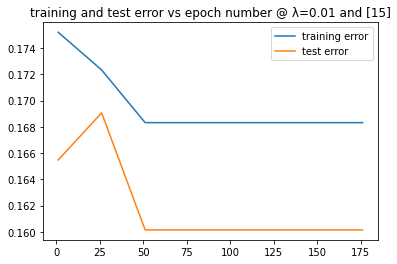

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

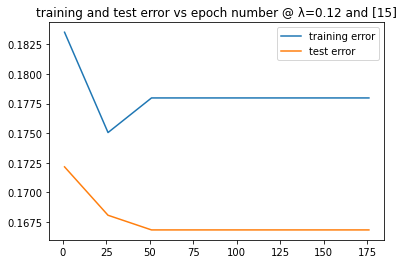

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

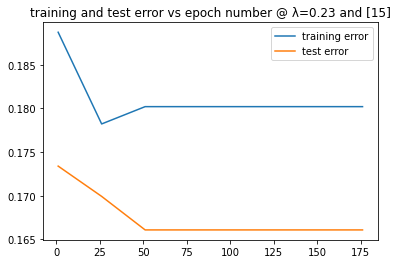

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

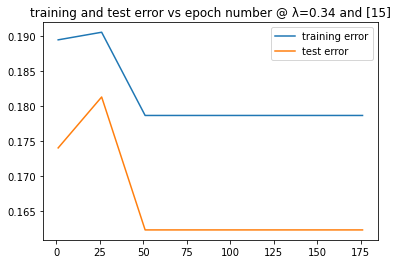

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

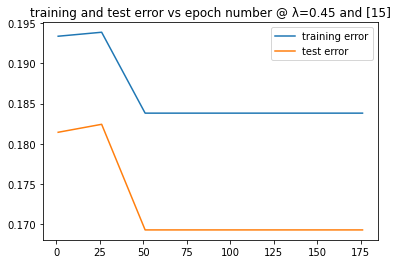

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

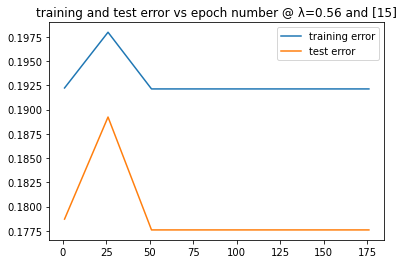

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

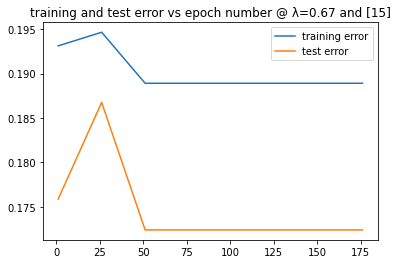

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

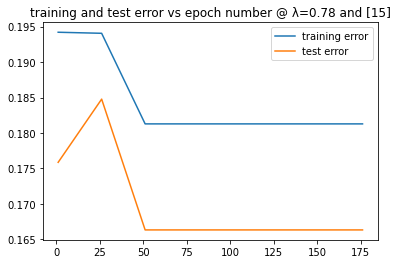

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

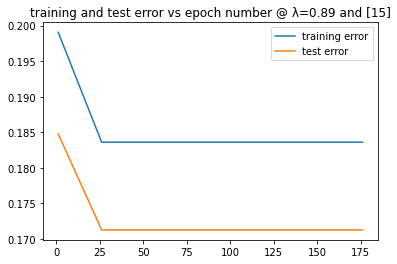

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

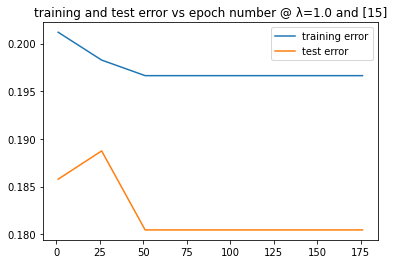

In [15]:
find_epochs_and_alpha(sub_train_train, sub_train_test, [40])

In [16]:
layers = [40]

scalar = StandardScaler()

xs_train_std = scalar.fit_transform(sub_train_train_xs)
xs_test_std = scalar.fit_transform(sub_train_test_xs)

mlp = MLPClassifier(hidden_layer_sizes=layers, activation='logistic', alpha=.01,
                            solver='adam', max_iter = 100, random_state=777,
                            learning_rate_init=.1, verbose=False)

mlp.fit(xs_train_std, sub_train_train_ys)

print(mlp.score(xs_test_std, sub_train_test_ys))

predictions = mlp.predict(xs_test_std)
summary = classification_report(sub_train_test_ys, predictions)
print(summary)

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

0.8349009900990099
              precision    recall  f1-score   support

           0       0.71      0.88      0.79      2767
           1       0.93      0.81      0.87      5313

    accuracy                           0.83      8080
   macro avg       0.82      0.85      0.83      8080
weighted avg       0.85      0.83      0.84      8080



### double layer, 40 neurons in each

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

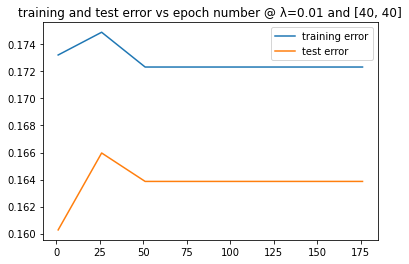

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

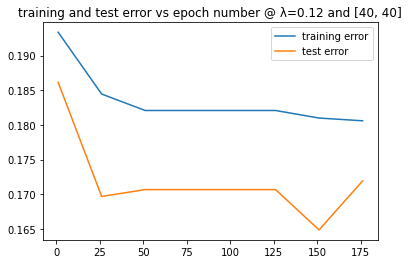

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

In [17]:
find_epochs_and_alpha(sub_train_train, sub_train_test, [40, 40])

In [17]:
layers = [40, 40]

scalar = StandardScaler()

xs_train_std = scalar.fit_transform(sub_train_train_xs)
xs_test_std = scalar.fit_transform(sub_train_test_xs)

mlp = MLPClassifier(hidden_layer_sizes=layers, activation='logistic', alpha=.01,
                            solver='adam', max_iter = 30, random_state=777,
                            learning_rate_init=.1, verbose=False)

mlp.fit(xs_train_std, sub_train_train_ys)

print(mlp.score(xs_test_std, sub_train_test_ys))

predictions = mlp.predict(xs_test_std)
summary = classification_report(sub_train_test_ys, predictions)
print(summary)

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

0.8268564356435644
              precision    recall  f1-score   support

           0       0.69      0.90      0.78      2767
           1       0.94      0.79      0.86      5313

    accuracy                           0.83      8080
   macro avg       0.81      0.84      0.82      8080
weighted avg       0.85      0.83      0.83      8080



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


## Triple layer, 40 neurons each

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

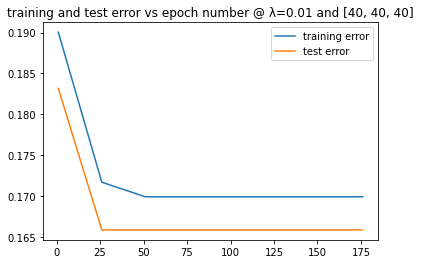

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

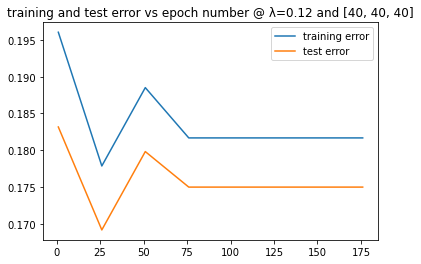

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

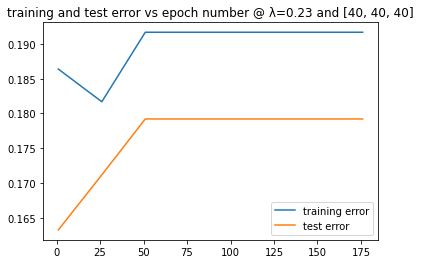

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

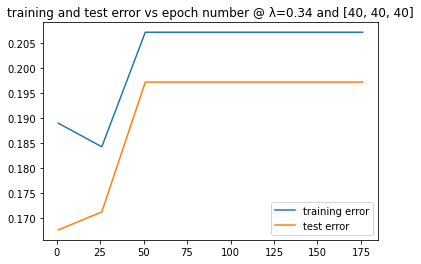

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

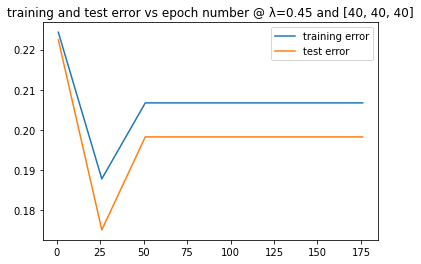

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

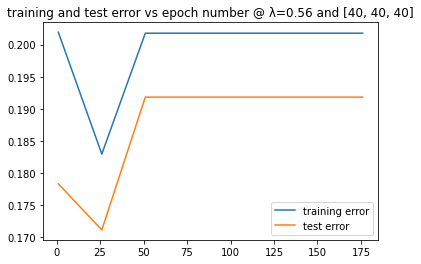

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

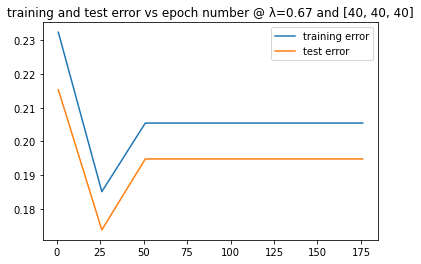

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

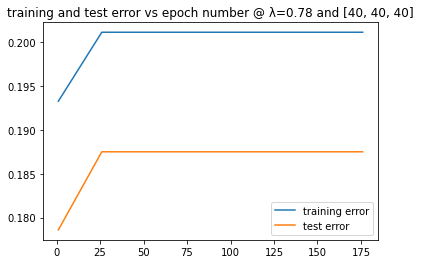

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

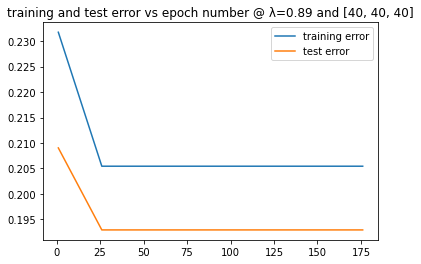

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

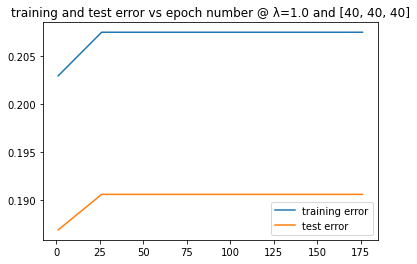

In [18]:
find_epochs_and_alpha(sub_train_train, sub_train_test, [40, 40, 40])

In [38]:
layers = [40, 40, 40]

scalar = StandardScaler()

xs_train_std = scalar.fit_transform(sub_train_train_xs)
xs_test_std = scalar.fit_transform(sub_train_test_xs)

mlp = MLPClassifier(hidden_layer_sizes=layers, activation='logistic', alpha=.01,
                            solver='adam', max_iter = 30, random_state=777,
                            learning_rate_init=.1, verbose=False)

mlp.fit(xs_train_std, sub_train_train_ys)

print(mlp.score(xs_test_std, sub_train_test_ys))

predictions = mlp.predict(xs_test_std)
summary = classification_report(sub_train_test_ys, predictions)
print(summary)

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

0.8362623762376238
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      2767
           1       0.88      0.87      0.88      5313

    accuracy                           0.84      8080
   macro avg       0.82      0.82      0.82      8080
weighted avg       0.84      0.84      0.84      8080



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


## Testing on the Validation Set

In [19]:
layers = [40, 40, 40]

scalar = StandardScaler()

xs_train_std = scalar.fit_transform(train_xs.values)
xs_test_std = scalar.fit_transform(val_test_xs.values)

mlp = MLPClassifier(hidden_layer_sizes=layers, activation='logistic', alpha=.01,
                            solver='adam', max_iter = 30, random_state=777,
                            learning_rate_init=.1, verbose=False)

mlp.fit(xs_train_std, train_ys)

print('SCORE: ', mlp.score(xs_test_std, val_test_ys.values))

y_pred_proba = mlp.predict_proba(val_test_xs)[::,1]
auc = metrics.roc_auc_score(val_test_ys.values, y_pred_proba)
print('AUC: ', auc)

predictions = mlp.predict(xs_test_std)
summary = classification_report(val_test_ys.values, predictions)
print(summary)

SCORE:  0.8431930693069307
AUC:  0.18478064759083962
              precision    recall  f1-score   support

           0       0.73      0.85      0.78      2686
           1       0.92      0.84      0.88      5394

    accuracy                           0.84      8080
   macro avg       0.82      0.84      0.83      8080
weighted avg       0.85      0.84      0.85      8080



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


# KNN

## Hyper-Parameter Tuning

In [21]:
scaler = StandardScaler()
xs_train_std = scaler.fit_transform(sub_train_train_xs.values)
xs_test_std = scaler.fit_transform(sub_train_test_xs.values)

for i in range(1, 33):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(xs_train_std, sub_train_train_ys)
    print(i, np.sqrt(mean_squared_error(sub_train_test_ys.values, knn.predict(xs_test_std))))

1 0.4592287982138216
2 0.46525304516961946
3 0.4412235463138637
4 0.4382684199446637
5 0.42580732871583926
6 0.42769240357903004
7 0.4199540286014814
8 0.4156588471664266
9 0.41326998343446236
10 0.41297040384928985
11 0.41252062654700394
12 0.4122205023700998
13 0.4092071542012737
14 0.41192015952339867
15 0.41026434366535963
16 0.4104151484282786
17 0.41101781416911415
18 0.4096605694696743
19 0.4078438839352214
20 0.4092071542012737
21 0.4081472263973401
22 0.4104151484282786
23 0.4064760414553701
24 0.40708453886407703
25 0.40341978725946903
26 0.4044921029960148
27 0.4035731496627506
28 0.4041860173653504
29 0.4044921029960148
30 0.4044921029960148
31 0.4051035804471359
32 0.40525630564782916


## Testing on Validation Set

In [23]:
scaler = StandardScaler()
xs_train_std = scaler.fit_transform(train_xs.values)
xs_test_std = scaler.fit_transform(val_test_xs.values)

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(xs_train_std, train_ys.values)
print('SCORE: ', knn.score(xs_test_std, val_test_ys.values))

y_pred_proba = knn.predict_proba(val_test_xs.values)[::,1]
auc = metrics.roc_auc_score(val_test_ys.values, y_pred_proba)
print('AUC: ', auc)

predictions = knn.predict(xs_test_std)
summary = classification_report(val_test_ys.values, predictions)
print(summary)

SCORE:  0.842079207920792
AUC:  0.7155256619762562
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      2686
           1       0.91      0.85      0.88      5394

    accuracy                           0.84      8080
   macro avg       0.82      0.84      0.83      8080
weighted avg       0.85      0.84      0.84      8080



# RF

## Hyper Parameter Tuning

In [24]:
classifier = RandomForestClassifier()
classifier.fit(sub_train_train_xs.values, sub_train_train_ys.values)

print(classifier.score(sub_train_test_xs.values, sub_train_test_ys.values))

predictions = classifier.predict(sub_train_test_xs.values)
summary = classification_report(sub_train_test_ys.values, predictions)
print(summary)

0.8451732673267327
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      2767
           1       0.90      0.86      0.88      5313

    accuracy                           0.85      8080
   macro avg       0.83      0.84      0.83      8080
weighted avg       0.85      0.85      0.85      8080



## Testing on the Validation Set

In [25]:
classifier = RandomForestClassifier()
classifier.fit(train_xs.values,train_ys.values)

print('SCORE: ', classifier.score(val_test_xs.values, val_test_ys.values))

y_pred_proba = classifier.predict_proba(val_test_xs.values)[::,1]
auc = metrics.roc_auc_score(val_test_ys.values, y_pred_proba)
print('AUC: ', auc)

predictions = classifier.predict(val_test_xs.values)
summary = classification_report(val_test_ys.values, predictions)
print(summary)


SCORE:  0.8549504950495049
AUC:  0.9252385582723254
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      2686
           1       0.92      0.86      0.89      5394

    accuracy                           0.85      8080
   macro avg       0.83      0.85      0.84      8080
weighted avg       0.86      0.85      0.86      8080



# Logistic GAM

## Hyper Parameter Tuning

In [11]:
logGAM1 = LogisticGAM() #unfortunately tuning takes too long and kills the kernel due to 26 parameters
logGAM1.fit(sub_train_test_xs, sub_train_test_ys)
print('SCORE: ', logGAM1.accuracy(sub_train_test_xs, sub_train_test_ys))

predictions = logGAM1.predict(sub_train_test_xs)
summary = classification_report(sub_train_test_ys, predictions)
print(summary)

SCORE:  0.8620049504950495
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2767
           1       0.90      0.89      0.89      5313

    accuracy                           0.86      8080
   macro avg       0.85      0.85      0.85      8080
weighted avg       0.86      0.86      0.86      8080



In [14]:
logGAM1 = LogisticGAM()
logGAM1.fit(train_xs, train_ys)

print('SCORE: ', logGAM1.accuracy(val_test_xs, val_test_ys))

y_pred_proba = logGAM1.predict_proba(val_test_xs.values)
print('here')
auc = metrics.roc_auc_score(val_test_ys, y_pred_proba)
print('AUC: ', auc)

predictions = logGAM1.predict(val_test_xs)
summary = classification_report(val_test_ys, predictions)
print(summary)

SCORE:  0.8419554455445545
here
AUC:  0.922498137115479
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      2686
           1       0.90      0.86      0.88      5394

    accuracy                           0.84      8080
   macro avg       0.82      0.83      0.83      8080
weighted avg       0.85      0.84      0.84      8080



# Trees

## Hyper Parameter Tuning

In [28]:
clf = tree.DecisionTreeClassifier(max_depth = 7)
clf.fit(sub_train_train_xs.values, sub_train_train_ys.values)


print('SCORE: ', clf.score(sub_train_test_xs.values, sub_train_test_ys.values))

predictions = clf.predict(sub_train_test_xs.values)
summary = classification_report(sub_train_test_ys.values, predictions)
print(summary)

SCORE:  0.8227722772277227
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2767
           1       0.87      0.86      0.86      5313

    accuracy                           0.82      8080
   macro avg       0.80      0.81      0.80      8080
weighted avg       0.82      0.82      0.82      8080



## Testing on the Validation Set

In [29]:
clf = tree.DecisionTreeClassifier(max_depth = 7)
clf.fit(train_xs.values,train_ys.values)

print('SCORE: ', clf.score(val_test_xs.values, val_test_ys.values))

y_pred_proba = clf.predict_proba(val_test_xs.values)[::,1]
auc = metrics.roc_auc_score(val_test_ys.values, y_pred_proba)
print('AUC: ', auc)

predictions = clf.predict(val_test_xs)
summary = classification_report(val_test_ys.values, predictions)
print(summary)

SCORE:  0.8330445544554456
AUC:  0.9097452120623809
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      2686
           1       0.90      0.85      0.87      5394

    accuracy                           0.83      8080
   macro avg       0.81      0.83      0.82      8080
weighted avg       0.84      0.83      0.84      8080



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


# SVC

## Hyper Parameter Tuning

In [9]:
#careful this takes 1.5 hours! Best parameters arre printed in the following cell
clf = SVC()

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
gridrbf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

gridrbf.fit(sub_train_train_xs.values, sub_train_train_ys.values)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

In [12]:
clf = SVC(C=100,gamma=.0001,kernel='rbf', probability=True)
#best parameters = {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

clf.fit(sub_train_train_xs.values, sub_train_train_ys.values)
print('SCORE: ', clf.score(sub_train_test_xs.values, sub_train_test_ys.values))
predictions = clf.predict(sub_train_test_xs.values)
summary = classification_report(sub_train_test_ys.values, predictions)
print(predictions)
print(summary)

SCORE:  0.8323019801980198
[0 1 0 ... 0 0 1]
              precision    recall  f1-score   support

           0       0.73      0.80      0.77      2767
           1       0.89      0.85      0.87      5313

    accuracy                           0.83      8080
   macro avg       0.81      0.83      0.82      8080
weighted avg       0.84      0.83      0.83      8080



# Testing on Validation Set

In [13]:
clf.fit(train_xs.values,train_ys.values)

print('SCORE: ', clf.score(val_test_xs.values, val_test_ys.values))

y_pred_proba = clf.predict_proba(val_test_xs.values)[::,1]
auc = metrics.roc_auc_score(val_test_ys.values, y_pred_proba)
print('AUC: ', auc)

predictions = clf.predict(val_test_xs)
summary = classification_report(val_test_ys.values, predictions)
print(summary)

SCORE:  0.8389851485148515
AUC:  0.8952849074465961


/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.73      0.82      0.77      2686
           1       0.90      0.85      0.88      5394

    accuracy                           0.84      8080
   macro avg       0.82      0.83      0.82      8080
weighted avg       0.85      0.84      0.84      8080



# Naive Bayes

## Hyper Parameter Tuning

In [10]:
clf = naive_bayes.MultinomialNB()
scaler = MinMaxScaler()
scaled_xs = scaler.fit_transform(sub_train_train_xs.values)
scaled_test_xs = scaler.fit_transform(sub_train_test_xs.values)
clf.fit(scaled_xs, sub_train_train_ys.values)


print('SCORE: ', clf.score(scaled_test_xs, sub_train_test_ys.values))

predictions = clf.predict(scaled_test_xs)
summary = classification_report(sub_train_test_ys.values, predictions)
print(summary)

SCORE:  0.8080445544554455
              precision    recall  f1-score   support

           0       0.71      0.74      0.72      2767
           1       0.86      0.85      0.85      5313

    accuracy                           0.81      8080
   macro avg       0.79      0.79      0.79      8080
weighted avg       0.81      0.81      0.81      8080



## Testing on the Validation Set

In [11]:
clf = naive_bayes.MultinomialNB()
scaler = MinMaxScaler()
scaled_xs = scaler.fit_transform(train_xs.values)
scaled_test_xs = scaler.fit_transform(val_test_xs.values)

clf.fit(scaled_xs, train_ys.values)

print('SCORE: ', clf.score(scaled_test_xs, val_test_ys.values))

y_pred_proba = clf.predict_proba(scaled_test_xs)[::,1]
auc = metrics.roc_auc_score(val_test_ys.values, y_pred_proba)
print('AUC: ', auc)

predictions = clf.predict(scaled_test_xs)
summary = classification_report(val_test_ys.values, predictions)
print(summary)

SCORE:  0.8131188118811881
AUC:  0.8836412234878885
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      2686
           1       0.87      0.84      0.86      5394

    accuracy                           0.81      8080
   macro avg       0.79      0.80      0.79      8080
weighted avg       0.82      0.81      0.81      8080



# XGBoosted Random Forest

## Hyper Parameter Tuning

In [61]:
classifier = XGBRFClassifier(max_depth=15)
classifier.fit(sub_train_train_xs.values, sub_train_train_ys.values)

print(classifier.score(sub_train_test_xs.values, sub_train_test_ys.values))

predictions = classifier.predict(sub_train_test_xs.values)
summary = classification_report(sub_train_test_ys.values, predictions)
print(summary)

/home/charlie/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:38:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8471534653465347
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      2767
           1       0.90      0.86      0.88      5313

    accuracy                           0.85      8080
   macro avg       0.83      0.84      0.83      8080
weighted avg       0.85      0.85      0.85      8080



## Testing on the Validation Set

In [62]:
model = XGBRFClassifier(max_depth=15)
model.fit(train_xs, train_ys)
print(model.score(val_test_xs.values, val_test_ys.values))

y_pred_proba = model.predict_proba(val_test_xs.values)[::,1]
auc = metrics.roc_auc_score(val_test_ys.values, y_pred_proba)
print('AUC: ', auc)

predictions = model.predict(val_test_xs.values)
summary = classification_report(val_test_ys.values, predictions)
print(summary)

/home/charlie/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/charlie/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:38:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.849009900990099
AUC:  0.9253083042822738
              precision    recall  f1-score   support

           0       0.74      0.83      0.79      2686
           1       0.91      0.86      0.88      5394

    accuracy                           0.85      8080
   macro avg       0.83      0.85      0.83      8080
weighted avg       0.86      0.85      0.85      8080



# The Winner

In [69]:
classifier = RandomForestClassifier()
classifier.fit(ninety_train_xs, ninety_train_ys)

print('SCORE: ', classifier.score(test_xs.values, test_ys.values))

y_pred_proba = classifier.predict_proba(test_xs.values)[::,1]
auc = metrics.roc_auc_score(test_ys.values, y_pred_proba)
print('AUC: ', auc)

predictions = classifier.predict(test_xs.values)
summary = classification_report(test_ys.values, predictions)
print(summary)

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


SCORE:  0.8521266073194856
AUC:  0.9276984440125813
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1377
           1       0.91      0.87      0.89      2667

    accuracy                           0.85      4044
   macro avg       0.83      0.85      0.84      4044
weighted avg       0.86      0.85      0.85      4044



# Experimentation with Bagging and Importance

<AxesSubplot:>

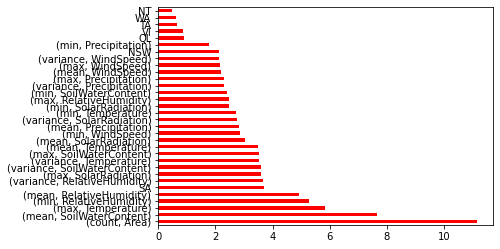

In [75]:
importance = pd.Series(classifier.feature_importances_ * 100, index = cols)
importance = importance.sort_values(axis=0, ascending = False)
importance.plot(kind='barh', color='r', )

In [13]:
cols2 = [('mean', 'RelativeHumidity'), ('min', 'RelativeHumidity'), ('max', 'Temperature'), ('mean', 'SoilWaterContent'), ('count', 'Area')]

classifier = RandomForestClassifier()
classifier.fit(ninety_train_xs[cols2], ninety_train_ys)

print('SCORE: ', classifier.score(test_xs[cols2].values, test_ys.values))

y_pred_proba = classifier.predict_proba(test_xs[cols2].values)[::,1]
auc = metrics.roc_auc_score(test_ys.values, y_pred_proba)
print('AUC: ', auc)

predictions = classifier.predict(test_xs[cols2].values)
summary = classification_report(test_ys.values, predictions)
print(summary)

/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


SCORE:  0.8303659742828883
AUC:  0.9103272493988359
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1377
           1       0.89      0.84      0.87      2667

    accuracy                           0.83      4044
   macro avg       0.81      0.82      0.82      4044
weighted avg       0.84      0.83      0.83      4044



# Experimentation with LogisticGAM

In [27]:
data = historicalWeather_pivot

def month_by_month(data):
    
    logGAM1 = LogisticGAM()
    
    for i in range(10):
        xs_train = data.iloc[0+30*i:30+30*i][cols]
        ys_train = data.iloc[0+30*i:30+30*i]['fire01']


        xs_test = data.iloc[60+30*i:90+30*i][cols]
        ys_test = data.iloc[60+30*i:90+30*i]['fire01']


        logGAM1 = LogisticGAM()
        logGAM1.fit(xs_train, ys_train)
        print(i)
        print('SCORE: ', logGAM1.accuracy(xs_test, ys_test))

        y_pred_proba = logGAM1.predict_proba(xs_test.values)
        auc = metrics.roc_auc_score(ys_test, y_pred_proba)
        print('AUC: ', auc)

        predictions = logGAM1.predict(xs_test)
        summary = classification_report(ys_test, predictions)
        print(summary)
        
month_by_month(data)

0
SCORE:  0.5
AUC:  0.8295454545454546
              precision    recall  f1-score   support

           0       0.35      1.00      0.52         8
           1       1.00      0.32      0.48        22

    accuracy                           0.50        30
   macro avg       0.67      0.66      0.50        30
weighted avg       0.83      0.50      0.49        30

did not converge
1
SCORE:  0.7666666666666667
AUC:  0.9316770186335405
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.77      1.00      0.87        23

    accuracy                           0.77        30
   macro avg       0.38      0.50      0.43        30
weighted avg       0.59      0.77      0.67        30



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2
SCORE:  0.7666666666666667
AUC:  0.6708074534161491
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.77      1.00      0.87        23

    accuracy                           0.77        30
   macro avg       0.38      0.50      0.43        30
weighted avg       0.59      0.77      0.67        30



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3
SCORE:  0.6666666666666666
AUC:  0.685
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.67      1.00      0.80        20

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4
SCORE:  0.8333333333333334
AUC:  0.7569444444444444
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.83      1.00      0.91        24

    accuracy                           0.83        30
   macro avg       0.91      0.58      0.60        30
weighted avg       0.86      0.83      0.78        30

5
SCORE:  0.6666666666666666
AUC:  0.6849999999999999
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.67      1.00      0.80        20

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6
SCORE:  0.4666666666666667
AUC:  0.59375
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.47      1.00      0.64        14

    accuracy                           0.47        30
   macro avg       0.23      0.50      0.32        30
weighted avg       0.22      0.47      0.30        30



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7
SCORE:  0.5
AUC:  0.88
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8
SCORE:  0.5
AUC:  0.8708133971291866
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        11
           1       1.00      0.21      0.35        19

    accuracy                           0.50        30
   macro avg       0.71      0.61      0.47        30
weighted avg       0.79      0.50      0.44        30

did not converge
9
SCORE:  0.8333333333333334
AUC:  0.9259259259259259
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.81      0.94      0.87        18

    accuracy                           0.83        30
   macro avg       0.85      0.81      0.82        30
weighted avg       0.84      0.83      0.83        30

